In [1]:
#!Clear Notebook Widget State

import json
import unittest
import time

import numpy as np
import scipy
from scipy import stats
from scipy.optimize import curve_fit
from scipy import constants
from numba import njit, jit
from tqdm import tqdm, trange

%matplotlib inline
import matplotlib # plotting libraries
from matplotlib import animation, rc, cm
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
%matplotlib widget
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

#import plotting as pl

from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.special import kn

In [2]:
Q = 1e6
wo = 2*np.pi*1.94*10e14 #Hz
Qo = 10*10e6
v = 220e3 #m/s
wm = 1e-2 #Hz
planck_mass = 2.176434e-8 #kg
l = 0.015 # cavity length. #EVAN ASSUMPTION.
sensor_mass = 1e-3 #kg.
sensor_density = 3.17*10**3 #silicon nitride
Pin = 1

T = 0.01 #K

pressure = 1e-10 #Pa

QNR = 10**(4.5)

# <center> Check the Noise Functions</center>

In [3]:
#solving for individual sections of the noise model. 
                     
def shot_noise(w,Pin,wo,Qo,l=l,w_m=wm,Q=Q,m=sensor_mass, use_G_opt=False, w_opt=1):
    
    h_bar = constants.hbar # checked.
    gamma = float(w_m) / float(Q) # damping. # checked. 
    m = float(m) #checked.
    k = wo/Qo #checked. 
    
    G = np.sqrt(2)*wo*np.sqrt(Pin/(h_bar*wo*k))/l # checked. 
    if use_G_opt:
        xc_opt = abs(k/(w_opt**2+(k**2)/4)) #checked
        xm_opt = abs((1/m**2)/((w_opt**2-w_m**2)**2+(gamma**2)*w_opt**2))#checked. 
        G = np.sqrt(1/(h_bar*(xc_opt)*(xm_opt)**0.5))
    abs_G = abs(G)
    
    abs_xc = abs(k/(w**2+(k**2)/4)) #checked
    abs_xm = abs((1/m**2)/((w**2-w_m**2)**2+(gamma**2)*w**2))#checked. 
    
    SN = 1/((abs_G**2)*(abs_xc)*(abs_xm))# checked.

    return SN
               
def back_action(w, Pin, wo, Qo,l=l,w_m=wm,Q=Q,m=sensor_mass, use_G_opt=False, w_opt=1):
    
    h_bar = constants.hbar
    gamma = float(w_m) / float(Q)
    k = wo/Qo
    G = np.sqrt(2)*wo*np.sqrt((Pin)/(h_bar*wo*k))/l # checked. 
    if use_G_opt:
        xc_opt = abs(k/(w_opt**2+(k**2)/4)) #checked
        xm_opt = abs((1/m**2)/((w_opt**2-w_m**2)**2+(gamma**2)*w_opt**2))#checked. 
        G = np.sqrt(1/(h_bar*(xc_opt)*(xm_opt)**0.5))
    abs_G = abs(G)
    
    xc = k/(w**2+(k**2)/4) # checked.
    abs_xc = abs(xc)

    BA = (h_bar**2)*(abs_G**2)*(abs_xc) #checked. 
   
    #print('BA is a ', type(BA))
    return BA
                 
def thermal_noise(m, T, w_m, Q):

    k_b = float(constants.k) # Boltzmann constant
    m = float(m) # mass of sensor
    T = float(np.array(T)) # temperature Kelvin
    gamma = float(w_m) / float(Q) # damping.

    TN = 4*k_b*m*T*gamma #checked. 
    #print('TN is a', type(TN))
    return TN

def thermal_noise_gas(T, sensor_mass=sensor_mass, sensor_density=sensor_density, pressure=pressure):

    k_b = float(constants.k) # Boltzmann constant
    gas_mass = 6.646e-27 # mass of Helium in kg.
    T = float(np.array(T)) # temperature Kelvin
    
    sensor_radius = (sensor_mass/(4/3*np.pi*sensor_density))**(1/3)
    sensor_area = (sensor_radius**2)*np.pi
    
    TN = pressure*sensor_area*np.sqrt(gas_mass*k_b*T)
    
    return TN

<IPython.core.display.Javascript object>


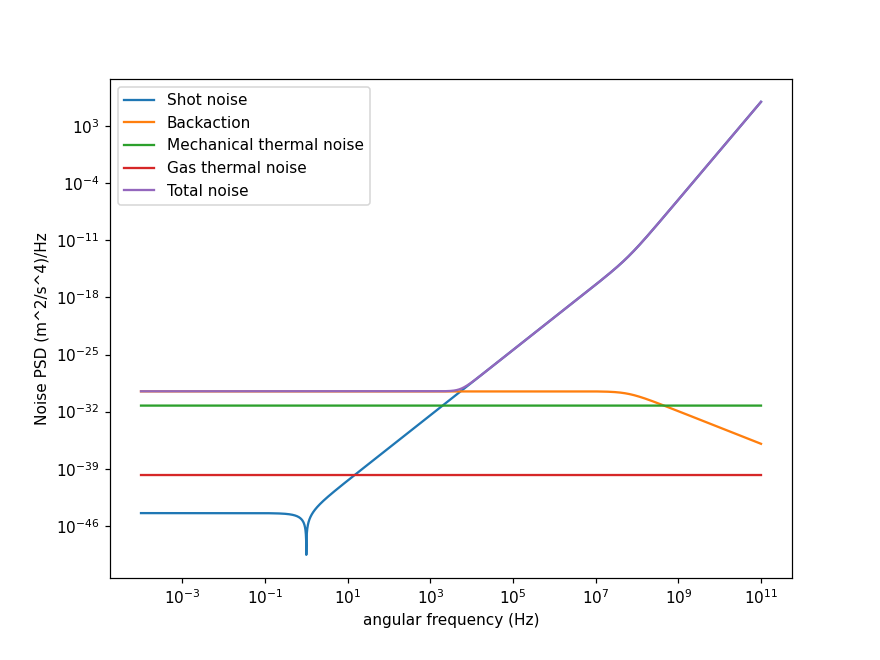

In [4]:
fig = plt.figure(figsize=(8, 6), dpi=110)
ax = fig.add_subplot(111)

X = np.logspace(-4,11,10000)
SN = shot_noise(X, Pin=Pin, wo=wo, Qo=Qo, w_m=1, Q=1e4, use_G_opt=False, w_opt=1e6)
BA = back_action(X, Pin=Pin, wo=wo, Qo=Qo, w_m=1, Q=1e4, use_G_opt=False, w_opt=1e6)
TN = thermal_noise(m=sensor_mass, T=0.01, w_m=1, Q=1e4)
TN_gas = thermal_noise_gas(T=0.01)

ax.plot(X, SN, label='Shot noise')
ax.plot(X, BA, label='Backaction')
ax.plot(X, [TN]*len(X), label='Mechanical thermal noise')
ax.plot(X, [TN_gas]*len(X), label='Gas thermal noise')

ax.plot(X, SN+BA+TN+TN_gas, label='Total noise')

ax.legend()
ax.set(xscale='log', yscale='log', ylabel='Noise PSD (m^2/s^4)/Hz', xlabel='angular frequency (Hz)')

plt.show()

# <center>Now It's Time For Interactions!!</center>

<IPython.core.display.Javascript object>


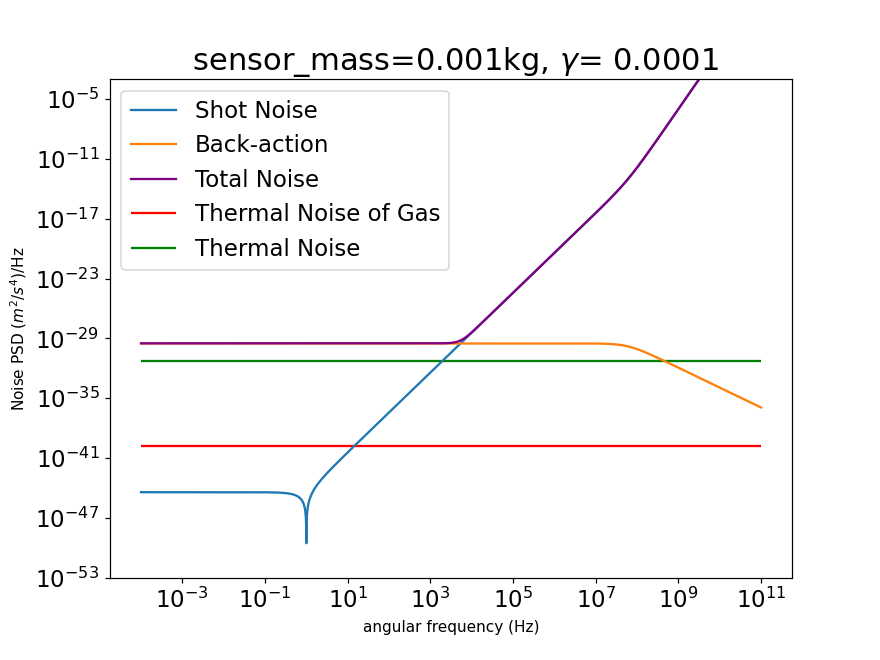

interactive(children=(FloatLogSlider(value=10000.0, description='Q', layout=Layout(width='80%'), max=8.0, step…

In [5]:
X = np.logspace(-4,11,10000)

fig = plt.figure(figsize=(8, 6), dpi=110)
ax = fig.add_subplot(1, 1, 1)

parameters = {'axes.labelsize': 20, 'axes.titlesize': 20, 'xtick.labelsize': 15, 'ytick.labelsize': 15, 'legend.fontsize':15}
plt.rcParams.update(parameters)

SN = shot_noise(X, Pin=Pin, wo=wo, Qo=Qo, w_m=1, Q=1e4, use_G_opt=False, w_opt=1e6)
BA = back_action(X, Pin=Pin, wo=wo, Qo=Qo, w_m=1, Q=1e4, use_G_opt=False, w_opt=1e6)
TN = thermal_noise(m=sensor_mass, T=0.01, w_m=1, Q=1e4)
TNG = thermal_noise_gas(T=0.01)

total_noise = SN+BA+TN+TNG

line_SN, = ax.plot(X, SN)
line_BA, = ax.plot(X, BA)
line_TN, = ax.plot([TN])
line_TNG, = ax.plot([TNG])
line_tot = ax.plot(X, total_noise) 

def update(Q=widgets.FloatLogSlider(value=1e4,base=10,min=0,max=8,step=1e-10,description='Q', layout=widgets.Layout(width='80%')), 
           w_m=widgets.FloatLogSlider(value=1,base=10,min=0,max=10,step=1e-10, description='w_m (Hz)', layout=widgets.Layout(width='80%')),
           wo=widgets.FloatLogSlider(value=2*np.pi*1.94*10e14,base=10,min=13,max=17,step=1e-10,description='w_0 (Hz)', layout=widgets.Layout(width='80%')),
           Qo=widgets.FloatLogSlider(value=10*10e6,base=10,min=6,max=10,step=1e-10,description='Q_0', layout=widgets.Layout(width='80%')),
           T=widgets.FloatSlider(value=0.01,min=0.01,max=400,step=0.01,description='T (K)', layout=widgets.Layout(width='80%')),
           Pin=widgets.FloatLogSlider(value=1,base=10,min=-5,max=14,step=1e-10,description='P_input (W)', layout=widgets.Layout(width='80%'))
           ):
    
    ax.clear()
    ax.set(xscale='log',yscale='log', ylabel='Noise PSD ($m^2$/$s^4$)/Hz', xlabel='angular frequency (Hz)', title=' sensor_mass='+str(sensor_mass)+'kg, $\gamma$= '+str(float('{:.8f}'.format(w_m/Q))))
    ax.set_ylim([1e-53, 1e-3])
    
    SN = shot_noise(X, Pin=Pin, wo=wo, Qo=Qo, w_m=w_m, Q=Q, use_G_opt=False, w_opt=1e6)
    BA = back_action(X, Pin=Pin, wo=wo, Qo=Qo, w_m=1, Q=1e4, use_G_opt=False, w_opt=1e6) 
    TN = thermal_noise_gas(T=T)
    TNG = thermal_noise(m=sensor_mass, T=T, w_m=w_m, Q=Q)
    
    total_noise = SN+BA+TN+TNG
    
    ax.plot(X, SN, label='Shot Noise')
    ax.plot(X, BA, label='Back-action')
    ax.hlines(TN, xmin=X[0],xmax=X[-1], color='red', label='Thermal Noise of Gas')
    ax.hlines(TNG,xmin=X[0],xmax=X[-1], color='green', label='Thermal Noise')
    ax.plot(X, total_noise, color='purple', label='Total Noise')
    
    ax.legend()
    # print("SN vs. w = ", shot_noise(X, 1, w_m=w_m, Q=Q, use_G_opt=True, w_opt=1e6))
    fig.canvas.draw_idle()
    
    print('min. freq.=', X[np.argmin(total_noise)], 'Hz, min. noise=', min(total_noise), 'm^2/s^4)/Hz')

interact(update);

In [6]:
def integrand_impulse_exponential(integral_var, impulse, Pin, wo=wo, Qo=Qo, T=T, QNR=1, w_m=wm, Q=Q):
    w = np.exp(integral_var)
    return impulse**2/(2*np.pi*(
        #shot_noise(X, Pin=Pin, wo=wo, Qo=Qo, w_m=1, Q=1e4, use_G_opt=False, w_opt=1e6)
        shot_noise(w, Pin, wo=wo, Qo=Qo, w_m=wm, Q=Q)/QNR**2 + back_action(w, Pin, wo=wo, Qo=Qo, w_m=wm, Q=Q)/QNR**2 +
        thermal_noise(m=sensor_mass, T=T, w_m=wm, Q=Q) +
        thermal_noise_gas(T=T)
    ))*w

In [7]:
impulse_SQL = np.sqrt(constants.hbar * sensor_mass * wm)
quad(integrand_impulse_exponential, -30, 7, args=(impulse_SQL, 1e-6))

(0.00015140238326155406, 6.818820629322319e-10)

In [8]:
from ipywidgets.embed import embed_minimal_html, dependency_state

s1 = IntSlider(max=200, value=100)
s2 = IntSlider(value=40)
embed_minimal_html('export.html', views=[s1, s2], state=dependency_state([s1, s2]))

In [ ]:
Pin_arr_edges = np.logspace(-15, 10, 200)
Pin_arr_centers = Pin_arr_edges[:-1] + np.diff(Pin_arr_edges)/2
SNR_arr = np.zeros_like(Pin_arr_centers)
for i,Pin in enumerate(tqdm(Pin_arr_centers)):
    SNR, err = quad(integrand_signal_model_exponential, -30, 40, args=(planck_mass, 5e-3, v, Pin, T, 10**(required_QNR_dB[0]/10), wm, Q, sensor_mass))
    SNR_arr[i] = np.sqrt(SNR)
fig = plt.figure(figsize=(8, 6), dpi=150)
ax = fig.add_subplot(111)
ax.plot(Pin_arr_centers, SNR_arr)
ax.set(xscale='log', ylabel='SNR', xlabel='Laser power (W)')
plt.show()

In [ ]:
max_index = np.argmax(SNR_arr)
optimal_laser_power = Pin_arr_centers[max_index]

cmap = cm.get_cmap('Dark2')
fig = plt.figure(figsize=(8, 6), dpi=150)
ax = fig.add_subplot(111)

X = np.logspace(-7,11,10000)
SN = shot_noise(X, optimal_laser_power, Q=Q, w_m=wm)/10**(required_QNR_dB[0]/10*2)
BA = back_action(X, optimal_laser_power, Q=Q, w_m=wm)/10**(required_QNR_dB[0]/10*2)
TN = thermal_noise(Q=Q, w_m=wm)
TN_gas = thermal_noise_gas()

ax.plot(X, SN, label='Shot noise', color=cmap(0))
ax.plot(X, BA, label='Backaction', color=cmap(1))
ax.plot(X, [TN]*len(X), label='Mechanical thermal noise', color=cmap(2))
ax.plot(X, [TN_gas]*len(X), label='Gas thermal noise', color=cmap(4))

ax.plot(X, SN+BA+TN+TN_gas, label='Total noise', color=cmap(5))

ax.legend()
ax.set(xscale='log', yscale='log', ylabel='Noise PSD (N^2)/Hz', xlabel='angular frequency (Hz)')

ax2 = ax.twinx()
ax2.plot(X, signal_model(X), color='red')
ax2.set(xscale='log', yscale='log', ylim=[1e-60, 1e-45])
ax2.set_ylabel('Force per freq squared (N^2/Hz^2)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.show()